# Advanced VQE Options

In the first algorithms tutorial, you learned how to set up a basic [VQE](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VQE.html) algorithm. Now, you will see how to provide more advanced configuration parameters to explore the full range of the variational algorithms provided in this library: [VQE](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VQE.html), [QAOA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.QAOA.html) and [VQD](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VQD.html) among others. In particular, this tutorial will cover how to set up a `callback` to monitor convergence and the use of custom `initial point`s and `gradient`s.

## Callback

Callback methods can be used to monitor optimization progress as the algorithm runs and converges to the minimum. The callback is invoked for each functional evaluation by the optimizer and provides the current optimizer value, evaluation count, current optimizer parameters etc. Note that, depending on the specific optimizer this may not be each iteration (step) of the optimizer, so for example if the optimizer is calling the cost function to compute a finite difference based gradient this will be visible via the callback.

This section demonstrates how to leverage callbacks in `VQE` to plot the convergence path to the ground state energy with a selected set of optimizers.

First, you need a qubit operator for VQE. For this example, you can use the same operator as used in the algorithms introduction, which was originally computed by [Qiskit Nature](https://qiskit-community.github.io/qiskit-nature/) for an H2 molecule.

In [1]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

The next step is to instantiate the `Estimator` of choice for the evaluation of expectation values within `VQE`. For simplicity, you can select the [qiskit.primitives.Estimator](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Estimator) that comes as part of Qiskit.

In [2]:
from qiskit.primitives import Estimator

estimator = Estimator()

In [3]:
type(estimator)

qiskit.primitives.estimator.Estimator

You are now ready to compare a set of optimizers through the `VQE` callback. The minimum energy of the H2 Hamiltonian can be found quite easily, so the maximum number of iterations (`maxiter`) does not have to be very large. You can once again use `TwoLocal` as the selected trial wavefunction (i.e. ansatz).

In [4]:
import numpy as np

from qiskit.circuit.library import TwoLocal

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_algorithms.utils import algorithm_globals

# we will iterate over these different optimizers
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")

    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print("\rOptimization complete      ");

Optimization complete      


Now, from the callback data you stored, you can plot the energy value at each objective function call each optimizer makes. An optimizer using a finite difference method for computing gradient has that characteristic step-like plot where for a number of evaluations it is computing the value for close by points to establish a gradient (the close by points having very similar values whose difference cannot be seen on the scale of the graph here).

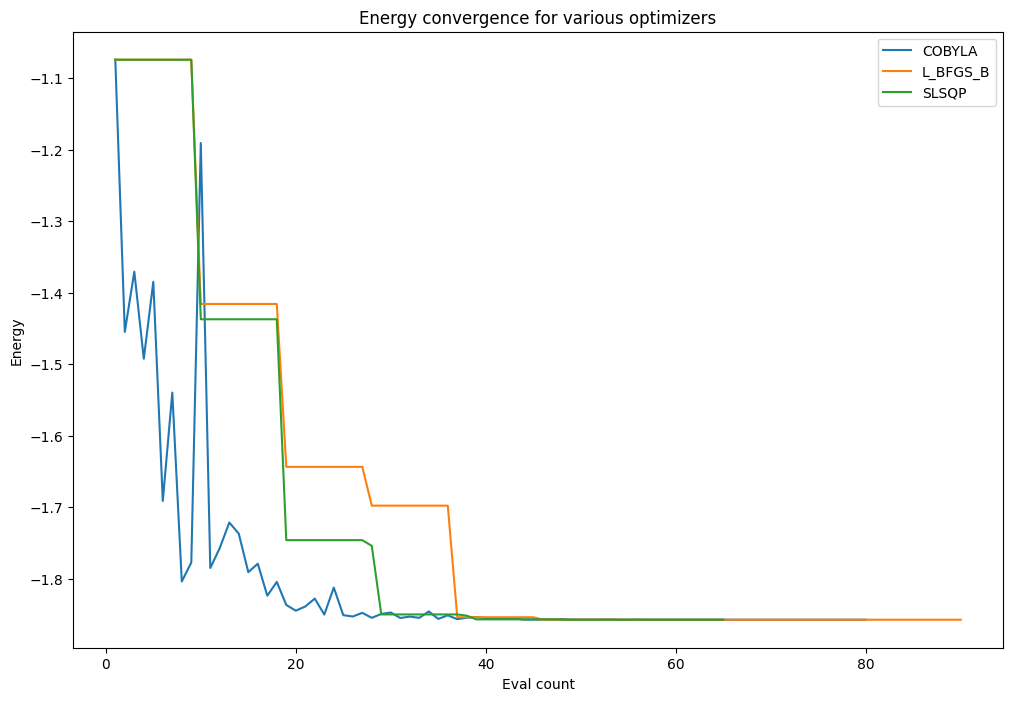

In [18]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_counts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

Finally, since the above problem is still easily tractable classically, you can use [NumPyMinimumEigensolver](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.NumPyMinimumEigensolver.html) to compute a reference value for the solution.

In [5]:
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.85728


You can now plot the difference between the `VQE` solution and this exact reference value as the algorithm converges towards the minimum energy.

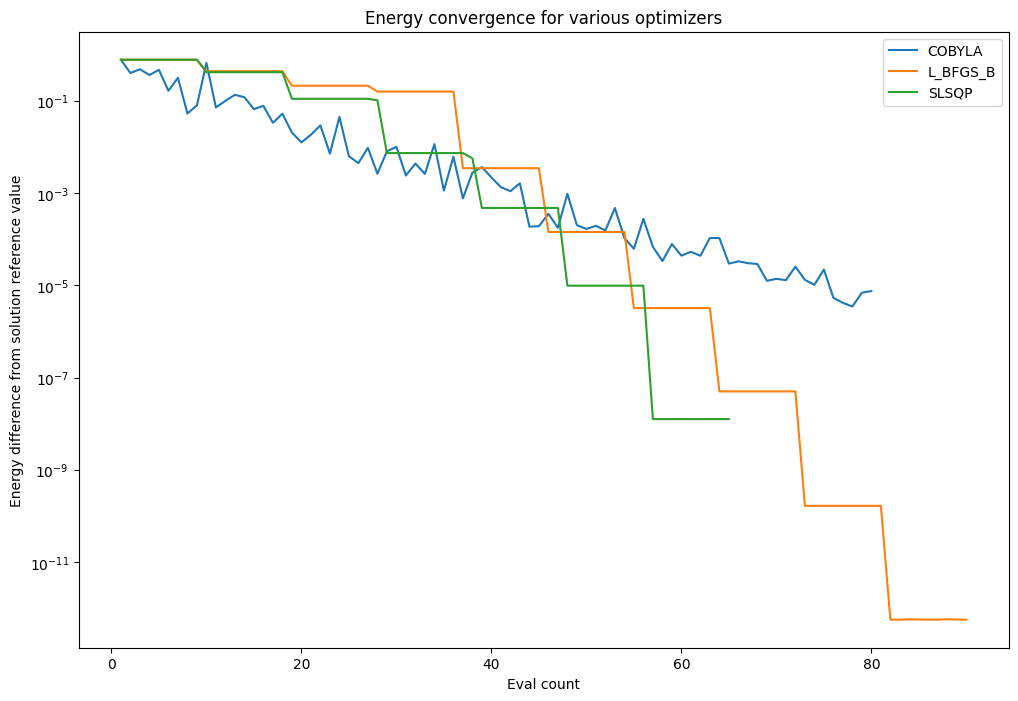

In [6]:
pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(
        converge_counts[i],
        abs(ref_value - converge_vals[i]),
        label=type(optimizer).__name__,
    )
pylab.xlabel("Eval count")
pylab.ylabel("Energy difference from solution reference value")
pylab.title("Energy convergence for various optimizers")
pylab.yscale("log")
pylab.legend(loc="upper right");

## Gradients

In the variational algorithms, if the provided optimizer uses a gradient-based technique, the default gradient method will be finite differences. However, these classes include an option to pass custom gradients via the `gradient` parameter, which can be any of the provided methods within the [gradient](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.gradients.html) framework, which fully supports the use of primitives. This section shows how to use custom gradients in the VQE workflow.

The first step is to initialize both the corresponding primitive and primitive gradient:

In [7]:
from qiskit_algorithms.gradients import FiniteDiffEstimatorGradient

estimator = Estimator()
gradient = FiniteDiffEstimatorGradient(estimator, epsilon=0.01)

Now, you can inspect an SLSQP run using the [FiniteDiffEstimatorGradient](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.gradients.FiniteDiffEstimatorGradient.html) from above:

In [8]:
algorithm_globals.random_seed = 50
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")

optimizer = SLSQP(maxiter=100)

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result, gradient=gradient)

result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f"Value using Gradient: {result.eigenvalue.real:.5f}")

Value using Gradient: -1.85728


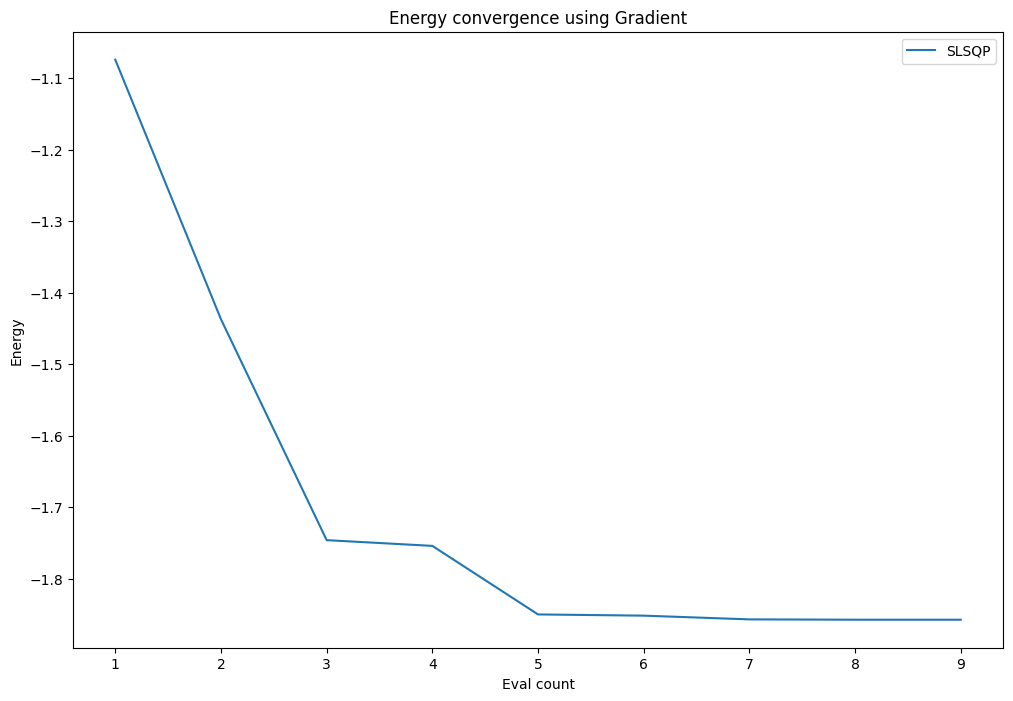

In [9]:
pylab.rcParams["figure.figsize"] = (12, 8)
pylab.plot(counts, values, label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence using Gradient")
pylab.legend(loc="upper right");

## Initial point

By default, the optimization begins at a random point within the bounds defined by the ansatz. The `initial_point` option allows to override this point with a custom list of values that match the number of ansatz parameters.

You might wonder... *Why set a custom initial point?* Well, this option can come in handy if you have a guess for a reasonable starting point for the problem, or perhaps know information from a prior experiment.

To demonstrate this feature, let's look at the results from our previous VQE run:

In [10]:
print(result)
cost_function_evals = result.cost_function_evals

{   'aux_operators_evaluated': None,
    'cost_function_evals': 9,
    'eigenvalue': -1.8572750175655808,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x000002106F7EB4F0>,
    'optimal_parameters': {   ParameterVectorElement(θ[2]): 0.5470777607659996,
                              ParameterVectorElement(θ[3]): 6.092947832766984,
                              ParameterVectorElement(θ[7]): 0.3602101747090273,
                              ParameterVectorElement(θ[6]): -4.717616147449762,
                              ParameterVectorElement(θ[4]): -2.5983266516732453,
                              ParameterVectorElement(θ[5]): 1.5683250498281969,
                              ParameterVectorElement(θ[0]): 4.296519450348696,
                              ParameterVectorElement(θ[1]): 4.426962358395526},
    'optimal_point': array([ 4.29651945,  4.42696236,  0.54707776,  6.09294783, -2.59832665,
        1.56832505, -4.71761615,  0.36021017]),
    'opti

Now, you can take the `optimal_point` from the above result and use it as the `initial_point` for a follow-up computation.

**Note:** `initial_point` is now a keyword-only argument of the `VQE` class (i.e, it must be set following the `keyword=value` syntax).

In [11]:
initial_pt = result.optimal_point

estimator1 = Estimator()
gradient1 = FiniteDiffEstimatorGradient(estimator, epsilon=0.01)
ansatz1 = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
optimizer1 = SLSQP(maxiter=1000)

vqe1 = VQE(estimator1, ansatz1, optimizer1, gradient=gradient1, initial_point=initial_pt)
result1 = vqe1.compute_minimum_eigenvalue(operator=H2_op)
print(result1)

cost_function_evals1 = result1.cost_function_evals
print()

{   'aux_operators_evaluated': None,
    'cost_function_evals': 1,
    'eigenvalue': -1.8572750175655814,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7ff6b996fee0>,
    'optimal_parameters': {   ParameterVectorElement(θ[6]): -4.717616147449735,
                              ParameterVectorElement(θ[7]): 0.3602101747090559,
                              ParameterVectorElement(θ[5]): 1.5683250498282117,
                              ParameterVectorElement(θ[4]): -2.598326651673345,
                              ParameterVectorElement(θ[0]): 4.296519450348804,
                              ParameterVectorElement(θ[2]): 0.547077760766061,
                              ParameterVectorElement(θ[3]): 6.0929478327669955,
                              ParameterVectorElement(θ[1]): 4.426962358395529},
    'optimal_point': array([ 4.29651945,  4.42696236,  0.54707776,  6.09294783, -2.59832665,
        1.56832505, -4.71761615,  0.36021017]),
    'optimal_v

In [12]:
print(
    f"cost_function_evals is {cost_function_evals1} with initial point versus {cost_function_evals} without it."
)

cost_function_evals is 1 with initial point versus 9 without it.


By looking at the `cost_function_evals` you can notice how the initial point helped the algorithm converge faster (in just 1 iteration, as we already provided the optimal solution).

This can be particularly useful in cases where we have two closely related problems, and the solution to one problem can be used to guess the other's. A good example might be plotting dissociation profiles in chemistry, where we change the inter-atomic distances of a molecule and compute its minimum eigenvalue for each distance. When the distance changes are small, we expect the solution to still be close to the prior one. Thus, a popular technique is to simply use the optimal point from one solution as the starting point for the next step. There also exist more complex techniques, where we can apply extrapolation to compute an initial position based on prior solution(s) rather than directly use the prior solution.

In [13]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright